In [7]:
import torch
import torch.nn as n 
import torchvision
from utils import logger
from configs import Configs

## bulid transform

In [9]:
train_transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
val_transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

## bulid dataset and dataloder

In [11]:
from datasets.catdogDataset import CatDogDataset
train_dataset=CatDogDataset("/root/classfier/data/train",mode="train",transform=train_transform)
val_dataset=CatDogDataset("/root/classfier/data/train",mode="valid",transform=val_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


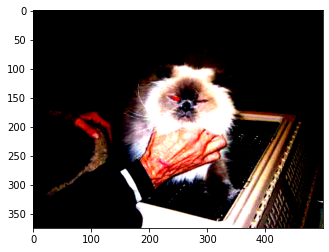

In [6]:
import matplotlib.pyplot as plt
img,label=train_dataset[0]
# HWC ===> CHW  WHC
plt.imshow(img.transpose(0,2).transpose(0,1))

In [12]:
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=Configs.bs[0],shuffle=True,drop_last=True)
val_loader=torch.utils.data.DataLoader(train_dataset,batch_size=1,shuffle=False,drop_last=True)
print(next(iter(train_loader)))

[tensor([[[[-1.2617, -1.2788, -1.2959,  ..., -0.8849, -0.8507, -0.8335],
          [-1.3815, -1.3644, -1.3473,  ..., -0.8849, -0.8507, -0.8335],
          [-1.4672, -1.4500, -1.3987,  ..., -0.8849, -0.8507, -0.8335],
          ...,
          [ 1.6324,  1.7180,  1.7523,  ...,  0.0912,  0.0912,  0.0741],
          [ 1.6838,  1.7180,  1.7180,  ...,  0.0912,  0.0741,  0.0227],
          [ 1.7009,  1.7180,  1.6838,  ...,  0.1083,  0.0569, -0.0116]],

         [[-1.2479, -1.2654, -1.2829,  ..., -0.7927, -0.7577, -0.7402],
          [-1.3880, -1.3880, -1.3529,  ..., -0.7927, -0.7577, -0.7402],
          [-1.5455, -1.5280, -1.4755,  ..., -0.7927, -0.7577, -0.7402],
          ...,
          [ 1.0805,  1.1681,  1.2206,  ...,  0.3803,  0.3627,  0.3277],
          [ 1.1331,  1.1681,  1.1681,  ...,  0.3627,  0.3102,  0.2577],
          [ 1.1506,  1.1681,  1.1506,  ...,  0.3102,  0.2577,  0.1877]],

         [[-1.0898, -1.1247, -1.1421,  ..., -0.4624, -0.4275, -0.4101],
          [-1.1944, -1.2119, 

In [13]:
# build device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
# build model
from models.ResNet import ResNet101_vd,ResNet18_vd,ResNet34_vd,ResNet50_vd
model=ResNet34_vd(num_classes=2)
model=model.to(device)

In [18]:
from torchsummary import summary 
summary(model,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
        Activation-4         [-1, 32, 128, 128]               0
            ConvBN-5         [-1, 32, 128, 128]               0
            Conv2d-6         [-1, 32, 128, 128]           9,216
       BatchNorm2d-7         [-1, 32, 128, 128]              64
              ReLU-8         [-1, 32, 128, 128]               0
        Activation-9         [-1, 32, 128, 128]               0
           ConvBN-10         [-1, 32, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          18,432
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
       Activation-14         [-1, 64, 1

In [19]:
# build loss
loss_fn=torch.nn.CrossEntropyLoss()
# build optimizer,lr_sheduler
optim=torch.optim.SGD(params=model.parameters(),lr=Configs.lr[0])\

sampler = torch.utils.data.SequentialSampler(train_dataset)
batch_sampler=torch.utils.data.sampler.BatchSampler(sampler,batch_size=Configs.bs[0],drop_last=True)
iter_per_epoch=len(batch_sampler)
lr_shed=torch.optim.lr_scheduler.OneCycleLR(optim,max_lr=Configs.lr[0],total_steps=(Configs.epochs[0]*iter_per_epoch))

In [20]:
for epoch in range(Configs.epochs[0]):
    for i,data in enumerate(train_loader):
        img,label=data
        img=img.to(device)
        label=label.to(device)

        model.train() # 训练模式===》 BatchNorm2d可以变化
        pred=model(img)
        
        loss=loss_fn(pred,label)
        loss.backward()
        optim.step()

        optim.clear_grad()


tensor([[[[ 1.0673,  1.0502,  1.0159,  ...,  0.8789,  0.8618,  0.8618],
          [ 1.0673,  1.0502,  1.0331,  ...,  0.8618,  0.8618,  0.8789],
          [ 1.0502,  1.0502,  1.0673,  ...,  0.8961,  0.8961,  0.8961],
          ...,
          [ 0.3309,  0.2796,  0.2624,  ...,  0.0056,  0.0056,  0.0569],
          [ 0.2796,  0.3309,  0.2796,  ...,  0.0056, -0.0458, -0.0801],
          [ 0.2967,  0.3138,  0.3481,  ..., -0.0287, -0.0629, -0.1143]],

         [[ 1.1331,  1.1155,  1.0805,  ...,  1.0105,  0.9930,  0.9930],
          [ 1.1331,  1.1155,  1.0980,  ...,  0.9930,  0.9930,  1.0105],
          [ 1.1155,  1.1155,  1.1331,  ...,  1.0280,  1.0280,  1.0280],
          ...,
          [ 0.5028,  0.4503,  0.4328,  ...,  0.1176,  0.1527,  0.2402],
          [ 0.4328,  0.5028,  0.4503,  ...,  0.1702,  0.1702,  0.1702],
          [ 0.4503,  0.4678,  0.5203,  ...,  0.2052,  0.1877,  0.1877]],

         [[ 1.0017,  0.9842,  0.9494,  ...,  0.7402,  0.7228,  0.7228],
          [ 1.0017,  0.9842,  